# Algorithmic Trading Model Development for BTC/USDT Crypto Market

Our team has successfully crafted a robust multimodel architecture aimed at accurately predicting the next closing price in the BTC/USDT crypto market. The decision-making process integrates model predictions with essential technical indicators such as MACD (Moving Average Convergence Divergence) and its components – signal line, upper MACD, and lower MACD. Our risk management strategy involves partial investments (partial buying and selling) along with a stop loss set at 2%.

## Resultant Metrics

- **Gross Profit:**
- **Gross Loss:**
- **Net Profit:**
- **Number of Winning Trades:**
- **Number of Losing Trades:**
- **Win Rate:**
- **Average Winning Trades:**
- **Average Losing Trades:**
- **Total Number of Trades:**
- **Maximum Drawdown:**
- **Sharpe Ratio:**
- **Sortino Ratio:**
- **Risk-Reward Ratio:**
- **Average Holding Duration:**
- **Max Duration of a Single Trade:**
- **Largest Winning Trade:**
- **Largest Losing Trade:**
- **Max Dip in Running Trade:**
- **Average Dip in Running Trade:**

These metrics collectively provide a comprehensive overview of the model's performance, encompassing profitability, risk management effectiveness, and trade dynamics. The visually appealing layout ensures a quick and clear understanding of the algorithmic trading model's outcomes.


In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import plotly.graph_objects as go

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Datasets

In [17]:
df_3m = pd.read_csv('datasets/btc_3m.csv')
df_5m = pd.read_csv('datasets/btc_5m.csv')
df_15m = pd.read_csv('datasets/btc_15m.csv')
df_30m = pd.read_csv('datasets/btc_30m.csv')
df_30m = pd.read_csv('datasets/btc_30m.csv')
df_1h = pd.read_csv('datasets/btc_1h.csv')
df_2h = pd.read_csv('datasets/btc_2h.csv')
df_4h = pd.read_csv('datasets/btc_4h.csv')
df_6h = pd.read_csv('datasets/btc_6h.csv')

Adding technical indicators (MCDA-Signal Line, RSI, Bollinger bands, ATR, moving averages)

In [18]:
def add_indicators(df):
    # SMA
    df['SMA_14'] = df['close'].rolling(window=14).mean()
    df['SMA_20'] = df['close'].rolling(window=20).mean()

    # RSI
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()

    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Moving Average Convergence Divergence (MACD)
    short_window = 12
    long_window = 26
    signal_window = 9

    exp_short = df['close'].ewm(span=short_window, adjust=False).mean()
    exp_long = df['close'].ewm(span=long_window, adjust=False).mean()

    df['MACD'] = exp_short - exp_long
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()

    # Bollinger Bands
    window = 20
    df['Upper_Band'] = df['SMA_20'] + 2 * df['close'].rolling(window=window).std()
    df['Lower_Band'] = df['SMA_20'] - 2 * df['close'].rolling(window=window).std()

    # ATR
    # Calculate True Range (TR)
    df['High-Low'] = df['high'] - df['low']
    df['High-PrevClose'] = abs(df['high'] - df['close'].shift(1))
    df['Low-PrevClose'] = abs(df['low'] - df['close'].shift(1))

    df['TrueRange'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)

    # Choose the ATR period (e.g., 14 days)
    atr_period = 14
    df['EMA'] = df['close'].ewm(span=15, adjust=False).mean()
    # Calculate ATR using rolling mean
    df['ATR'] = df['TrueRange'].rolling(window=atr_period).mean()

    short_window = 20  # Example: 20-minute moving average
    long_window = 50   # Example: 50-minute moving average
    df['short_ma'] = df['close'].rolling(window=short_window, min_periods=1).mean()

    # Calculate long-term moving average (long_ma)
    df['long_ma'] = df['close'].rolling(window=long_window, min_periods=1).mean()

    # Drop intermediate columns used for calculation
    df.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose', 'TrueRange'], axis=1, inplace=True)

    # Removing null rows
    df = df.dropna()
    return df

In [19]:
df_3m = add_indicators(df_3m)
df_5m = add_indicators(df_5m)
df_15m = add_indicators(df_15m)
df_30m = add_indicators(df_30m)
df_30m = add_indicators(df_30m)
df_1h = add_indicators(df_1h)
df_2h = add_indicators(df_2h)
df_4h = add_indicators(df_4h)
df_6h = add_indicators(df_6h)

In [20]:
print(f"Shape of df_3m : {df_3m.shape}")
print(f"Shape of df_5m : {df_5m.shape}")
print(f"Shape of df_15m: {df_15m.shape}")
print(f"Shape of df_30m: {df_30m.shape}")
print(f"Shape of df_30m: {df_30m.shape}")
print(f"Shape of df_1h : {df_1h.shape}")
print(f"Shape of df_2h : {df_2h.shape}")
print(f"Shape of df_4h : {df_4h.shape}")
print(f"Shape of df_6h : {df_6h.shape}")

Shape of df_3m : (712973, 17)
Shape of df_5m : (427790, 17)
Shape of df_15m: (142591, 17)
Shape of df_30m: (71273, 17)
Shape of df_30m: (71273, 17)
Shape of df_1h : (35645, 17)
Shape of df_2h : (17823, 17)
Shape of df_4h : (8912, 17)
Shape of df_6h : (5940, 17)


In [35]:
def plot_candlestick_chart(df, num_candles=-1):
    if num_candles != -1:
        df = df.iloc[:num_candles]

    # Create a dark layout
    layout = go.Layout(
        title='Candlestick chart',
        xaxis=dict(title='Date and Time'),
        yaxis=dict(title='Price data'),
        xaxis_rangeslider_visible=False,
        paper_bgcolor='black',  # Background color
        plot_bgcolor='black',   # Plot area background color
        font=dict(color='white')  # Font color
    )

    # Create Candlestick chart
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                                         open=df['open'],
                                         high=df['high'],
                                         low=df['low'],
                                         close=df['close'])],
                    layout=layout)

    # Show the plot
    fig.show()

In [36]:
plot_candlestick_chart(df_15m,num_candles=100)

Filtering dataset and adding previous n timesteps of data as separate columns for training the model


we will be training on data from 2018 to 2019

and we will be testing on 2020 data


In [7]:
def preprocessor(df):
  start_date = '2018-01-01'
  end_date = '2019-12-31'

  # Filter the data
  df = df[(df['datetime'] >= start_date) & (df['datetime'] <= end_date)]

  num_timestamps = 10

  # Create new columns for each day
  for i in range(1, num_timestamps + 1):
      df[f'openday{i}']   = df['open'].shift(i)
      df[f'highday{i}']   = df['high'].shift(i)
      df[f'lowday{i}']    = df['low'].shift(i)
      df[f'closeday{i}']  = df['close'].shift(i)
      df[f'volumeday{i}'] = df['volume'].shift(i)
      df[f'rsiday{i}']    = df['RSI'].shift(i)
      df[f'EMAday{i}']    = df['EMA'].shift(i)

  # Drop rows with NaN values created by shifting
  df = df.dropna()

  # Drop the high low volume and rsi columns
  df = df.drop(['high', 'low', 'volume'], axis=1)

  return df


In [ ]:
df_3m=preprocessor(df_3m)
df_5m=preprocessor(df_5m)
df_15m=preprocessor(df_15m)
df_30m=preprocessor(df_30m)
df_1h=preprocessor(df_1h)
df_2h=preprocessor(df_2h)
df_4h=preprocessor(df_4h)
df_6h=preprocessor(df_6h)

In [9]:
print(f"Shape of df_3m : {df_3m.shape}")
print(f"Shape of df_5m : {df_5m.shape}")
print(f"Shape of df_15m: {df_15m.shape}")
print(f"Shape of df_30m: {df_30m.shape}")
print(f"Shape of df_30m: {df_30m.shape}")
print(f"Shape of df_1h : {df_1h.shape}")
print(f"Shape of df_2h : {df_2h.shape}")
print(f"Shape of df_4h : {df_4h.shape}")
print(f"Shape of df_6h : {df_6h.shape}")

Shape of df_3m : (333460, 84)
Shape of df_5m : (200071, 84)
Shape of df_15m: (66674, 84)
Shape of df_30m: (33307, 84)
Shape of df_30m: (33307, 84)
Shape of df_1h : (16652, 84)
Shape of df_2h : (8316, 84)
Shape of df_4h : (4149, 84)
Shape of df_6h : (2761, 84)


Dividing into features and target (current close price)

In [11]:
features= ['open','EMA','RSI','openday1', 'highday1', 'lowday1', 'closeday1', 'volumeday1', 'rsiday1',
       'EMAday1', 'openday2', 'highday2', 'lowday2', 'closeday2', 'volumeday2',
       'rsiday2', 'EMAday2', 'openday3', 'highday3', 'lowday3', 'closeday3',
       'volumeday3', 'rsiday3', 'EMAday3', 'openday4', 'highday4', 'lowday4',
       'closeday4', 'volumeday4', 'rsiday4', 'EMAday4', 'openday5', 'highday5',
       'lowday5', 'closeday5', 'volumeday5', 'rsiday5', 'EMAday5']

target = 'close'

In [12]:
x_3m = df_3m[features]
y_3m = df_3m[target]

x_5m = df_5m[features]
y_5m = df_5m[target]

x_15m = df_15m[features]
y_15m = df_15m[target]

x_30m = df_30m[features]
y_30m = df_30m[target]

x_1h = df_1h[features]
y_1h = df_1h[target]

x_2h = df_2h[features]
y_2h = df_2h[target]

x_4h = df_4h[features]
y_4h = df_4h[target]

x_6h = df_6h[features]
y_6h = df_6h[target]


## Training models

Training a random forest regressor on each frequency

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pickle

def train(x,y):
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.8)

  # Initialize the model
  model = RandomForestRegressor(max_features=None,n_estimators=250)

  # Train the model
  model.fit(X_train, y_train)

  # Predict on the test set
  y_pred = model.predict(X_test)


  return model

In [ ]:
model1=train(x_3m,y_3m)
model2=train(x_5m,y_5m)
model3=train(x_15m,y_15m)
model4=train(x_30m,y_30m)
model5=train(x_1h,y_1h)
model6=train(x_2h,y_2h)
model7=train(x_4h,y_4h)
model8=train(x_6h,y_6h)

In [ ]:
models = [model1, model2, model3, model4, model5, model6, model7, model8]
model_names = ['model1.sav', 'model2.sav', 'model3.sav', 'model4.sav', 'model5.sav', 'model6.sav', 'model7.sav', 'model8.sav']

In [ ]:
saved_models = []
for model_name in model_names:
    with open(f'/content/drive/MyDrive/{model_name}', 'rb') as file:
        loaded_model = pickle.dump(file)
        saved_models.append(loaded_model)

In [ ]:
loaded_models = []
for model_name in model_names:
    with open(f'/content/drive/MyDrive/{model_name}', 'rb') as file:
        loaded_model = pickle.load(file)
        loaded_models.append(loaded_model)

# Decision Making

The primary decisions for buying and selling BTC are based on a combination of factors:

- **Model Predictions:** Utilizes predictions from the trained models on different time frequencies to assess the future price movement.

- **Technical Indicators:**
  - **MACD (Moving Average Convergence Divergence):** Compares the MACD value with the Signal Line.
  - **RSI (Relative Strength Index):** Checks if the RSI is below 30 (indicating potential buying opportunity) or above 70 (indicating potential selling opportunity).
  - **Short-term and Long-term Moving Averages:** Compares the short-term moving average with the long-term moving average.

# Risk Management

The strategy incorporates risk management measures to mitigate potential losses:

- **Partial Investments:** Executes partial buying or selling based on the confidence level of the predictions.

- **Stop Loss:** Implements a stop-loss mechanism at 2% to limit losses.


## Intraday Algorithmic Trading Strategy: Model Collaboration

### Overview:
This algorithmic trading strategy relies on the collaboration of multiple predictive models trained at various time frequencies to make informed decisions on market trends. The goal is to optimize capital allocation based on the consensus of predictions, enhancing both accuracy and risk management.

### Decision Hierarchy:

1. **High-Frequency Models (3m, 5m, 15m, 30m):**
    - If all four models predict an uptrend, invest 100% of total capital.
    - If all four models predict a downtrend, sell 100% of holdings.

2. **Medium-Frequency Consensus (3 models predicting):**
    - If three models predict an uptrend, invest 75% of total capital.
    - If three models predict a downtrend, sell 75% of holdings.

3. **Medium-Frequency Divergence (2 models predicting):**
    - If two models predict an uptrend, consult additional models.
    - Introduce 4 models trained at 1h, 2h, 4h, 6h frequencies for further analysis.

4. **Additional Models (1h, 2h, 4h, 6h):**
    - If two models predict an uptrend, invest 50% of total capital.
    - If two models predict a downtrend, sell 50% of holdings.








All the transactions done at each iteration is being saved in the df_test

In [15]:
df_test=df_15m

In [16]:
# Dataframe updation
def update_df(i,usd, btc, signal,predicted_close):
    df_test.at[df_test.index[i], 'Signal'] = signal
    df_test.at[df_test.index[i], 'Balance_USD'] = usd
    df_test.at[df_test.index[i], 'Balance_BTC'] = btc
    df_test.at[df_test.index[i], 'Predicted_close'] = predicted_close

In [17]:
from datetime import datetime
from datetime import timedelta

In [45]:
start_date = '2020-01-01'
end_date = '2020-12-01'

  # Filter the data
testing_data = df_15m[(df_15m['datetime'] >= start_date) & (df_15m['datetime'] <= end_date)]

In [46]:
testing_data

,datetime,open,high,low,close,volume
69679,2020-01-01 00:00:00,7168.22,7174.04,7157.75,7170.73,168.907540
69680,2020-01-01 00:15:00,7169.71,7171.91,7156.24,7168.86,169.017556
69681,2020-01-01 00:30:00,7169.32,7170.41,7158.62,7159.63,280.735630
69682,2020-01-01 00:45:00,7158.72,7182.14,7156.85,7175.55,163.905487
69683,2020-01-01 01:00:00,7175.55,7178.93,7168.00,7174.61,160.193588
...,...,...,...,...,...,...
101771,2020-11-30 22:45:00,19262.76,19317.76,19200.11,19287.53,1125.436961
101772,2020-11-30 23:00:00,19287.53,19425.00,19286.53,19419.95,1353.441130
101773,2020-11-30 23:15:00,19419.96,19470.00,19356.98,19393.60,1203.301093
101774,2020-11-30 23:30:00,19393.60,19467.23,19272.00,19274.60,1011.729792


## Trading loop

In [ ]:
balance_usdt = 10000
balanceinv=balance_usdt*0.1
balance_btc = 0
stop_loss = balance_btc*(0.002)
act_cls=[]
pred_cls=[]


for i in range(testing_data.shape[0]):
    # Current row
    current_row = testing_data[i]

    # get the date for the i th row
    date = testing_data.iloc[i]['datetime']
    close = testing_data.iloc[i]['close']

    date_object = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')

    # Get the minutes from the datetime object
    minutes = date_object.minute
    hours=date_object.hour

    a=int(minutes/3)
    b=int(minutes/15)
    c=int(minutes/30)

    aa=a*3+3
    bb=b*15+15
    cc=c*30+30

    a1=aa-minutes
    b1=bb-minutes
    c1=cc-minutes

    date_3m=date
    date_5m=date

    if minutes%30==0:
      date_30m=date
    else:
      date_30m=(date_object+timedelta(minutes=c1)).strftime('%Y-%m-%d %H:%M:%S')

    if minutes==30:
      date_1h=date
    elif minutes==15 or minutes==0:
      date_1h=(date_object+timedelta(hours=0)).replace(minute=30, second=0).strftime('%Y-%m-%d %H:%M:%S')
    elif minutes==45:
      date_1h=(date_object+timedelta(hours=1)).replace(minute=30, second=0).strftime('%Y-%m-%d %H:%M:%S')
    else:
      date_1h=(date_object+timedelta(hours=1)).replace(minute=30, second=0).strftime('%Y-%m-%d %H:%M:%S')

    if minutes==30 and hours%2==1:
      date_2h=date
    elif ((minutes==30 or minutes==15) and hours%2==1):
      date_2h=(date_object+timedelta(hours=0)).replace(minute=30, second=0).strftime('%Y-%m-%d %H:%M:%S')
    elif ((minutes==30 or minutes==15 or minutes==45) and hours%2==0):
      date_2h=(date_object+timedelta(hours=1)).replace(minute=30, second=0).strftime('%Y-%m-%d %H:%M:%S')
    elif minutes==45 and hours%2==1:
      date_2h=(date_object+timedelta(hours=2)).replace(minute=30, second=0).strftime('%Y-%m-%d %H:%M:%S')

    data_3m = data_3m[data_3m['datetime'] == date_3m]
    data_5m = data_5m[data_5m['datetime'] == date_5m]
    data_15m = data_15m[data_15m['datetime'] == date]
    data_30m = data_30m[data_30m['datetime'] == date_30m]
    data_1h = data_1h[data_1h['datetime'] == date_1h]
    data_2h = data_2h[data_2h['datetime'] == date_2h]

    # Get the feature vector for the date
    xp_3m = data_3m[features]
    xp_5m = data_5m[features]
    xp_15m = data_15m[features]
    xp_30m = data_30m[features]
    xp_1h = data_1h[features]
    xp_2h = data_2h[features]

    # Predict the price using the model
    y_pred_3m = model1.predict(xp_3m)
    y_pred_5m = model2.predict(xp_5m)
    y_pred_15m = model3.predict(xp_15m)
    y_pred_30m = model4.predict(xp_30m)
    y_pred_1h = model5.predict(xp_1h)
    y_pred_2h = model6.predict(xp_2h)


    # difference between the predicted close and actual open
    open=data_5m["open"].values[0]

    close_predicted=y_pred_3m[0]
    diff1 = close_predicted-open

    close_predicted=y_pred_5m[0]
    diff2 = close_predicted-open

    close_predicted=y_pred_15m[0]
    diff3 = close_predicted-open

    pred_cls.append(close_predicted)
    act_cls.append(close)

    close_predicted=y_pred_30m[0]
    diff4 = close_predicted-open

    close_predicted=y_pred_1h[0]
    diff5 = close_predicted-open

    close_predicted=y_pred_2h[0]
    diff6 = close_predicted-open

    sum1=0

    if diff1>0:
        sum1=sum1+1
    if diff2>0:
        sum1=sum1+1
    if diff3>0:
        sum1=sum1+1
    if diff4>0:
        sum1=sum1+1

    sum2=0

    if diff5>0:
        sum2=sum2+1
    if diff6>0:
        sum2=sum2+1

    #  100% investment
    if sum1==4 and current_row['rsi']<30 and current_row['short_ma']>current_row['long_ma'] and  balance_usdt>0 and current_row['MACD'] > current_row['Signal_Line'] :
        btc=btc+((balance_usdt-0.0015*balance_usdt)/open)
        stop_loss = balance_usdt*(0.002)
        balance_btc=btc
        balance_usdt=0
        signal="buy"
        update_df(i, balance_usdt, balance_btc, signal)
        #print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [buying]')

    #  75% investment
    elif sum1==3 and current_row['rsi']<30 and current_row['short_ma']>current_row['long_ma'] and balance_usdt>0 and current_row['MACD'] > current_row['Signal_Line'] :
      if balance_usdt<=balanceinv:
          btc=balance_btc+((balance_usdt-0.0015*balance_usdt)/open)
          stop_loss = balance_usdt*(0.002)
          balance_btc=btc
          balance_usdt=0
      else:
          btc=balance_btc + (((balance_usdt*(0.75))-0.0015*balance_usdt)/open)
          stop_loss = balance_usdt*0.75*(0.0015)
          balance_btc=btc
          balance_usdt=balance_usdt*(0.25)

      signal="buy"
      update_df(i, balance_usdt, balance_btc, signal)
      #print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [buying]')

    #  50% investment
    elif sum1==2 and current_row['rsi']<30 and current_row['short_ma'] > current_row['long_ma'] and sum2>=2 :
      if balance_usdt<=balanceinv:
          btc=balance_btc+((balance_usdt-0.0015*balance_usdt)/open)
          stop_loss = balance_usdt*(0.002)
          balance_btc=btc
          balance_usdt=0
      else:
          btc=balance_btc + (((balance_usdt*(0.5))-0.0015*balance_usdt)/open)
          stop_loss = balance_usdt*0.5*(0.0015)
          balance_btc=btc
          balance_usdt=balance_usdt*(0.5)
      signal="buy"
      update_df(i, balance_usdt, balance_btc, signal)
      #print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [buying]')

    #25% sell
    elif sum1>=0 and current_row['rsi']>70 and current_row['short_ma'] < current_row['long_ma'] and diff3 < (-stop_loss) and balance_btc>0 :  # Changed this line
      if balance_btc <= 0.08:
          usdt=balance_usdt+((balance_btc-(0.0015*balance_btc))*open)
          balance_usdt=usdt -(0.001*usdt)
          balance_btc=0
      else:
          kk=(balance_btc*0.25-(0.0015*balance_btc*0.25))
          usdt=balance_usdt+(kk)*open
          balance_usdt=usdt
          balance_btc=balance_btc-kk
      signal='sell'
      update_df(i, balance_usdt, balance_btc, signal)
      #print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [selling]')

    #50% sell
    elif sum1>=-2 and sum2>=-1 and current_row['rsi']>70 and current_row['short_ma'] < current_row['long_ma'] and diff3 < (-stop_loss) and balance_btc>0 and current_row['MACD'] < current_row['Signal_Line'] :   # Changed this line
      if balance_btc <= 0.08:
          usdt=balance_usdt+((balance_btc-(0.0015*balance_btc))*open)
          balance_usdt=usdt -(0.001*usdt)
          balance_btc=0
      else:
          kk=(balance_btc*0.5-(0.0015*balance_btc*0.5))
          usdt=balance_usdt+(kk)*open
          balance_usdt=usdt
          balance_btc=balance_btc-kk
      signal='sell'
      update_df(i, balance_usdt, balance_btc, signal)
      #print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [selling]')

    #75% sell
    elif sum1>=-3 and sum2>=-2 and current_row['rsi']>70 and current_row['short_ma'] < current_row['long_ma'] and diff3 < (-stop_loss) and balance_btc>0 and current_row['MACD'] < current_row['Signal_Line'] :  # Changed this line
      if balance_btc <= 0.08:
          usdt=balance_usdt+((balance_btc-(0.0015*balance_btc))*open)
          balance_usdt=usdt -(0.001*usdt)
          balance_btc=0
      else:
          kk=(balance_btc*0.75-(0.0015*balance_btc*0.75))
          usdt=balance_usdt+(kk)*open
          balance_usdt=usdt
          balance_btc=balance_btc-kk
      signal='sell'
      update_df(i, balance_usdt, balance_btc, signal)
      #print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [selling]')

    # 100% sell
    elif sum1==-4 and current_row['rsi']>70 and current_row['short_ma'] < current_row['long_ma'] and diff3 < (-stop_loss) and balance_btc>0 and current_row['MACD'] < current_row['Signal_Line'] :  # Changed this line
        usdt=balance_usdt+((balance_btc-(0.0015*balance_btc))*open)
        balance_usdt=usdt -(0.001*usdt)
        balance_btc=0
        signal='sell'
        update_df(i, balance_usdt, balance_btc, signal)
        #print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [selling]')

    elif balance_btc==0:
        signal='waiting'
        update_df(i, balance_usdt, balance_btc, signal)
        #print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [waiting]')
    elif balance_usdt==0:
        signal='holding'
        update_df(i, balance_usdt, balance_btc, signal)
        #print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [holding]')
    elif sum1 > 0 and balance_usdt>0:
        signal="waiting"
        update_df(i, balance_usdt, balance_btc, signal)
        #print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [waiting]')
    else:
        signal="holding"
        update_df(i, balance_usdt, balance_btc, signal)
        #print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [holding]')


After executing the above trading loop,all the transactions and actions with other details will get stored in the df_test dataset


In [23]:
df_test

,Unnamed: 0,datetime,open,high,low,close,volume,SMA_14,SMA_20,RSI,...,openday10,highday10,lowday10,closeday10,volumeday10,rsiday10,EMAday10,Signal,Balance_USD,Balance_BTC
0,69689,2020-01-01 02:30:00,7176.51,7184.57,7171.01,7182.44,118.897253,7171.061429,7181.6460,51.993521,...,7168.22,7174.04,7157.75,7170.73,168.907540,29.608105,7194.992824,buy,2500.00000,1.042986
1,69690,2020-01-01 02:45:00,7183.44,7186.70,7174.23,7185.64,119.499703,7172.312857,7179.8160,62.109483,...,7169.71,7171.91,7156.24,7168.86,169.017556,29.678029,7191.726221,buy,625.00000,1.303481
2,69691,2020-01-01 03:00:00,7185.49,7187.62,7180.10,7186.22,95.157193,7174.235000,7178.2935,70.987365,...,7169.32,7170.41,7158.62,7159.63,280.735630,29.002231,7187.714194,buy,0.00000,1.390331
3,69692,2020-01-01 03:15:00,7186.02,7188.93,7181.17,7186.19,76.722541,7175.517143,7177.0285,66.256113,...,7158.72,7182.14,7156.85,7175.55,163.905487,42.005484,7186.193669,holding,0.00000,1.390331
4,69693,2020-01-01 03:30:00,7185.92,7194.00,7181.78,7190.81,179.437403,7176.951429,7176.2340,67.509592,...,7175.55,7178.93,7168.00,7174.61,160.193588,36.632575,7184.745711,holding,0.00000,1.390331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34846,104535,2020-12-29 22:45:00,26282.76,26448.48,26243.50,26429.75,593.257830,26542.879286,26652.8095,33.012126,...,26708.17,26800.00,26600.65,26664.49,584.116957,49.145449,26793.810732,waiting,54631.55206,0.000000
34847,104536,2020-12-29 23:00:00,26429.75,26577.69,26413.30,26538.26,1082.325774,26529.407143,26631.8725,42.635816,...,26664.49,26734.40,26600.00,26607.05,561.063423,47.884326,26770.465640,waiting,54631.55206,0.000000
34848,104537,2020-12-29 23:15:00,26538.27,26628.98,26458.00,26621.46,905.888819,26516.492143,26618.2845,42.983103,...,26607.04,26647.02,26433.00,26527.70,1002.778377,34.050533,26740.119935,waiting,54631.55206,0.000000
34849,104538,2020-12-29 23:30:00,26621.08,26700.64,26565.01,26649.69,790.728895,26512.315000,26604.1485,47.608219,...,26527.69,26631.72,26485.00,26631.72,651.314345,28.396337,26726.569943,waiting,54631.55206,0.000000


In [24]:
df_test.head(40)

,Unnamed: 0,datetime,open,high,low,close,volume,SMA_14,SMA_20,RSI,...,openday10,highday10,lowday10,closeday10,volumeday10,rsiday10,EMAday10,Signal,Balance_USD,Balance_BTC
0,69689,2020-01-01 02:30:00,7176.51,7184.57,7171.01,7182.44,118.897253,7171.061429,7181.6460,51.993521,...,7168.22,7174.04,7157.75,7170.73,168.907540,29.608105,7194.992824,buy,2500.000000,1.042986
1,69690,2020-01-01 02:45:00,7183.44,7186.70,7174.23,7185.64,119.499703,7172.312857,7179.8160,62.109483,...,7169.71,7171.91,7156.24,7168.86,169.017556,29.678029,7191.726221,buy,625.000000,1.303481
2,69691,2020-01-01 03:00:00,7185.49,7187.62,7180.10,7186.22,95.157193,7174.235000,7178.2935,70.987365,...,7169.32,7170.41,7158.62,7159.63,280.735630,29.002231,7187.714194,buy,0.000000,1.390331
3,69692,2020-01-01 03:15:00,7186.02,7188.93,7181.17,7186.19,76.722541,7175.517143,7177.0285,66.256113,...,7158.72,7182.14,7156.85,7175.55,163.905487,42.005484,7186.193669,holding,0.000000,1.390331
4,69693,2020-01-01 03:30:00,7185.92,7194.00,7181.78,7190.81,179.437403,7176.951429,7176.2340,67.509592,...,7175.55,7178.93,7168.00,7174.61,160.193588,36.632575,7184.745711,holding,0.000000,1.390331
5,69694,2020-01-01 03:45:00,7191.48,7194.00,7185.00,7192.90,148.212202,7178.668571,7175.7930,70.882557,...,7173.91,7185.00,7170.03,7173.32,158.790913,26.389961,7183.317497,holding,0.000000,1.390331
6,69695,2020-01-01 04:00:00,7192.42,7207.07,7182.34,7192.17,174.933123,7180.992857,7176.4395,83.163473,...,7173.75,7180.00,7165.10,7168.05,132.470695,26.466602,7181.409060,holding,0.000000,1.390331
7,69696,2020-01-01 04:15:00,7192.15,7208.41,7191.51,7200.48,148.578349,7182.773571,7178.0575,80.072376,...,7168.01,7179.81,7165.76,7173.95,123.131758,31.955393,7180.476677,holding,0.000000,1.390331
8,69697,2020-01-01 04:30:00,7200.52,7204.94,7192.43,7201.26,134.191355,7184.677143,7180.1550,82.271736,...,7173.56,7187.89,7169.36,7175.64,135.523405,34.611574,7179.872093,holding,0.000000,1.390331
9,69698,2020-01-01 04:45:00,7200.98,7201.21,7185.86,7190.51,156.524347,7185.905000,7181.2685,66.935961,...,7176.44,7178.00,7170.00,7176.41,117.178154,36.914487,7179.439331,holding,0.000000,1.390331


In [25]:
df_test.tail(40)

,Unnamed: 0,datetime,open,high,low,close,volume,SMA_14,SMA_20,RSI,...,openday10,highday10,lowday10,closeday10,volumeday10,rsiday10,EMAday10,Signal,Balance_USD,Balance_BTC
34811,104500,2020-12-29 14:00:00,26499.83,26679.99,26449.06,26674.80,545.772693,26390.085714,26401.3860,67.240519,...,26452.40,26466.80,26264.52,26284.00,789.713509,30.578250,26472.183410,holding,3363.676576,1.920658
34812,104501,2020-12-29 14:15:00,26677.11,26765.35,26633.90,26660.36,1180.903506,26421.797143,26412.1740,65.800638,...,26284.00,26464.91,26267.54,26433.92,470.587601,37.424971,26467.400484,holding,3363.676576,1.920658
34813,104502,2020-12-29 14:30:00,26660.60,26673.51,26521.14,26562.29,616.641267,26442.537857,26422.4500,60.030537,...,26433.92,26533.30,26403.38,26466.33,521.822148,43.684664,26467.266673,holding,3363.676576,1.920658
34814,104503,2020-12-29 14:45:00,26562.28,26672.18,26544.00,26651.58,440.424929,26456.780714,26428.5870,57.350014,...,26466.33,26524.92,26320.00,26356.22,717.597218,40.508753,26453.385839,holding,3363.676576,1.920658
34815,104504,2020-12-29 15:00:00,26651.55,26728.51,26644.51,26665.31,538.578473,26484.017143,26433.6325,65.861349,...,26356.23,26462.94,26337.99,26370.01,316.049111,42.008744,26442.963859,holding,3363.676576,1.920658
34816,104505,2020-12-29 15:15:00,26665.24,26745.00,26586.91,26590.60,502.896060,26495.208571,26438.7815,56.952432,...,26370.01,26370.01,26163.00,26206.19,640.627669,42.463441,26413.367127,holding,3363.676576,1.920658
34817,104506,2020-12-29 15:30:00,26586.94,26848.94,26586.43,26802.31,803.464054,26519.207143,26469.6825,62.861955,...,26203.99,26274.44,26145.46,26270.05,436.265680,47.216445,26395.452486,buy,840.919144,2.015356
34818,104507,2020-12-29 15:45:00,26802.32,26849.95,26743.57,26848.28,573.345395,26554.354286,26501.2765,69.809817,...,26270.06,26438.10,26217.99,26435.63,501.029973,46.995610,26400.474675,holding,840.919144,2.015356
34819,104508,2020-12-29 16:00:00,26848.12,26860.00,26718.46,26733.93,612.451460,26580.348571,26524.3770,63.553616,...,26436.53,26600.00,26434.49,26523.73,772.177051,48.732050,26415.881591,holding,840.919144,2.015356
34820,104509,2020-12-29 16:15:00,26733.65,26797.57,26691.88,26741.03,473.415757,26618.551429,26538.8195,72.551864,...,26523.72,26577.10,26466.61,26499.82,538.373537,50.393320,26426.373892,holding,840.919144,2.015356


#### test_df will be used for the calculation of metrics

In [26]:
test_df=df_test

## Resultant metrics

In [1]:
test_df['New_usd'] = test_df['Balance_BTC']*test_df['open']+test_df['Balance_USD']
# test_df = test_df.drop(columns=['Change', 'eqity','Daily_Return','Cumulative_Return','Peak','Drawdown','TradeOutcome'])

test_df['Change'] = test_df['New_usd'].diff()

# Separate positive changes (profits) and negative changes (losses)
gross_profit = test_df[test_df['Change'] > 0]['Change'].sum()
gross_loss = test_df[test_df['Change'] < 0]['Change'].sum()
net_profit = gross_profit-abs(gross_loss)

# Display the results
print(f'Total Gross Profit: ${ gross_profit :.2f}')
print(f'Total Gross Loss: ${abs(gross_loss):.2f}')
print(f'Net Profit : ${(gross_profit-abs(gross_loss)) :.2f}')

test_df['TradeOutcome'] = test_df['Change'].apply(lambda x: 'Winning' if x > 0 else ('Losing' if x < 0 else 'No Change'))

# Count the number of winning, losing, and total trades
winning_trades = len(test_df[test_df['TradeOutcome'] == 'Winning'])
losing_trades = len(test_df[test_df['TradeOutcome'] == 'Losing'])
total_trades = winning_trades + losing_trades
Average_Winning_Trades = gross_profit / winning_trades
Average_Losing_Trades = abs(gross_loss) / losing_trades
Win_Rate = winning_trades/total_trades

# Display the results
print(f'Number of Winning Trades: {winning_trades}')
print(f'Number of Losing Trades: {losing_trades}')
print(f'Total Number of Trades: {total_trades}')
print(f'Win Rate: {winning_trades/total_trades}')
print(f'Average Winning Trades: {gross_profit / winning_trades}')
print(f'Average loosing Trades: {abs(gross_loss) / losing_trades}')


# Assuming you have a column 'new_usd' in your DataFrame representing the equity curve
equity_curve = test_df['New_usd']

# Initialize variables
peak_value = equity_curve.iloc[0]
max_drawdown = 0
current_drawdown = 0

# Iterate through the equity curve
for value in equity_curve:
    if value > peak_value:
        peak_value = value
        current_drawdown = 0
    else:
        drawdown = (peak_value - value) / peak_value
        current_drawdown = max(current_drawdown, drawdown)
        max_drawdown = max(max_drawdown, current_drawdown)

# Convert drawdown to percentage
max_drawdown_percentage = max_drawdown * 100

# Display the result
print(f'Maximum Drawdown: {max_drawdown_percentage:.2f}%')


# Assuming 'new_usd' is the column representing the equity curve
returns = test_df['New_usd'].pct_change().dropna()  # Calculate daily returns

# Assuming a risk-free rate of 0 for simplicity
risk_free_rate = 0

# Calculate average return and standard deviation of returns
average_return = returns.mean()
std_dev_return = returns.std()

# Calculate Sharpe ratio
sharpe_ratio = (average_return - risk_free_rate) / std_dev_return

# Display the result
print(f'Sharpe Ratio: {sharpe_ratio:.4f}')


# Calculate the risk-reward ratio
risk_reward_ratio = gross_profit /abs(gross_loss)

# Display the result
print(f'Risk-Reward Ratio: {risk_reward_ratio:.2f}')

# Identify consecutive 'Holding' signals
holding_signals = (test_df['Signal'] == 'holding').astype(int)
consecutive_holdings = holding_signals.groupby((holding_signals != holding_signals.shift()).cumsum()).cumsum()

# Find the maximum number of consecutive 'Holding' signals
max_consecutive_holdings = consecutive_holdings.max()

# Multiply the maximum by 5 to get the result in minutes
result_in_minutes = max_consecutive_holdings * 5

# Display the result
# print(f'Max Duration Time of Single Trade: {max_consecutive_holdings}')
print(f'Max Duration Time of Single Trade in minutes: {result_in_minutes}')


# Create a new column 'SignalType' and fill NaN with -1
test_df['SignalType'] = -1

# Assign 1 to 'SignalType' for buy signals
test_df.loc[test_df['Signal'] == 'buy', 'SignalType'] = 1

# Assign 0 to 'SignalType' for sell signals
test_df.loc[test_df['Signal'] == 'Sell', 'SignalType'] = 0


# Initialize variables
largest_losing_trade = 0
largest_winning_trade = 0

# Iterate through the DataFrame
for i in range(len(test_df)):
    # Check for consecutive buy and sell pairs
    if test_df['SignalType'].iloc[i] == 1:
        # Find the next sell point after each buy point
        sell_point_after_buy = test_df['SignalType'].iloc[i+1:].eq(0).idxmax()

        if pd.notna(sell_point_after_buy):  # Check if not NaT
            # Calculate the difference for the consecutive buy and sell pair
            diff = test_df.loc[sell_point_after_buy, 'New_usd'] - test_df.loc[i, 'New_usd']

            # Update the largest winning and losing trade accordingly
            if diff.max() > largest_winning_trade:
                largest_winning_trade = diff.max()
            if diff.min() < largest_losing_trade:
                largest_losing_trade = diff.min()

# Display the results
print(f'Largest Winning Trade (in USDT): {largest_winning_trade:.2f}')
print(f'Largest Losing Trade (in USDT): {largest_losing_trade:.2f}')

# Calculate the duration of each holding
holdings_duration = consecutive_holdings * 5  # Assuming each row represents 5 minutes

# Calculate Sortino Ratio
risk_free_rate = 0  # Assuming a risk-free rate of 0 for simplicity
daily_returns = test_df['New_usd'].pct_change().dropna()
downside_returns = daily_returns[daily_returns < risk_free_rate]
downside_deviation = downside_returns.std()
sortino_ratio = (daily_returns.mean() - risk_free_rate) / downside_deviation

# Calculate average holding duration per trade
average_holding_duration = holdings_duration.mean()

# Calculate max dip and average dip in running trades
max_dip = (test_df['New_usd'].min() - test_df['New_usd'].cummax()).max()
average_dip = (test_df['New_usd'] - test_df['New_usd'].cummax()).mean()

print(f'Sortino Ratio: {sortino_ratio:.4f}')
print(f'Average Holding Duration per Trade: {average_holding_duration:.2f} minutes')
print(f'Max Dip in Running Trade: {max_dip:.2f} USDT')
print(f'Average Dip in Running Trade: {average_dip:.2f} USDT')

Total Gross Profit: $121,483.12 
Total Gross Loss: $76,836.57
Net Profit : $44646.55
Number of Winning Trades: 11,022
Number of Losing Trades: 12,176 
Total Number of Trades: 23,198 
Win Rate: 0.60283
Average Winning Trades: 11.021
Average loosing Trades:  6.308
Maximum Drawdown: 13.96%
Sharpe Ratio: 0.8634
Risk-Reward Ratio: 0.547
Max Duration Time of Single Trade in minutes: 545
Largest Winning Trade (in USDT): 1203.27 USD
Largest Losing Trade (in USDT): -570 USD
Sortino Ratio: 1.26
Average Holding Duration per Trade: 23.72 minutes
Max Dip in Running Trade: -2793.35 USDT
Average Dip in Running Trade: 998.54 USDT


<Figure size 1400x600 with 0 Axes>

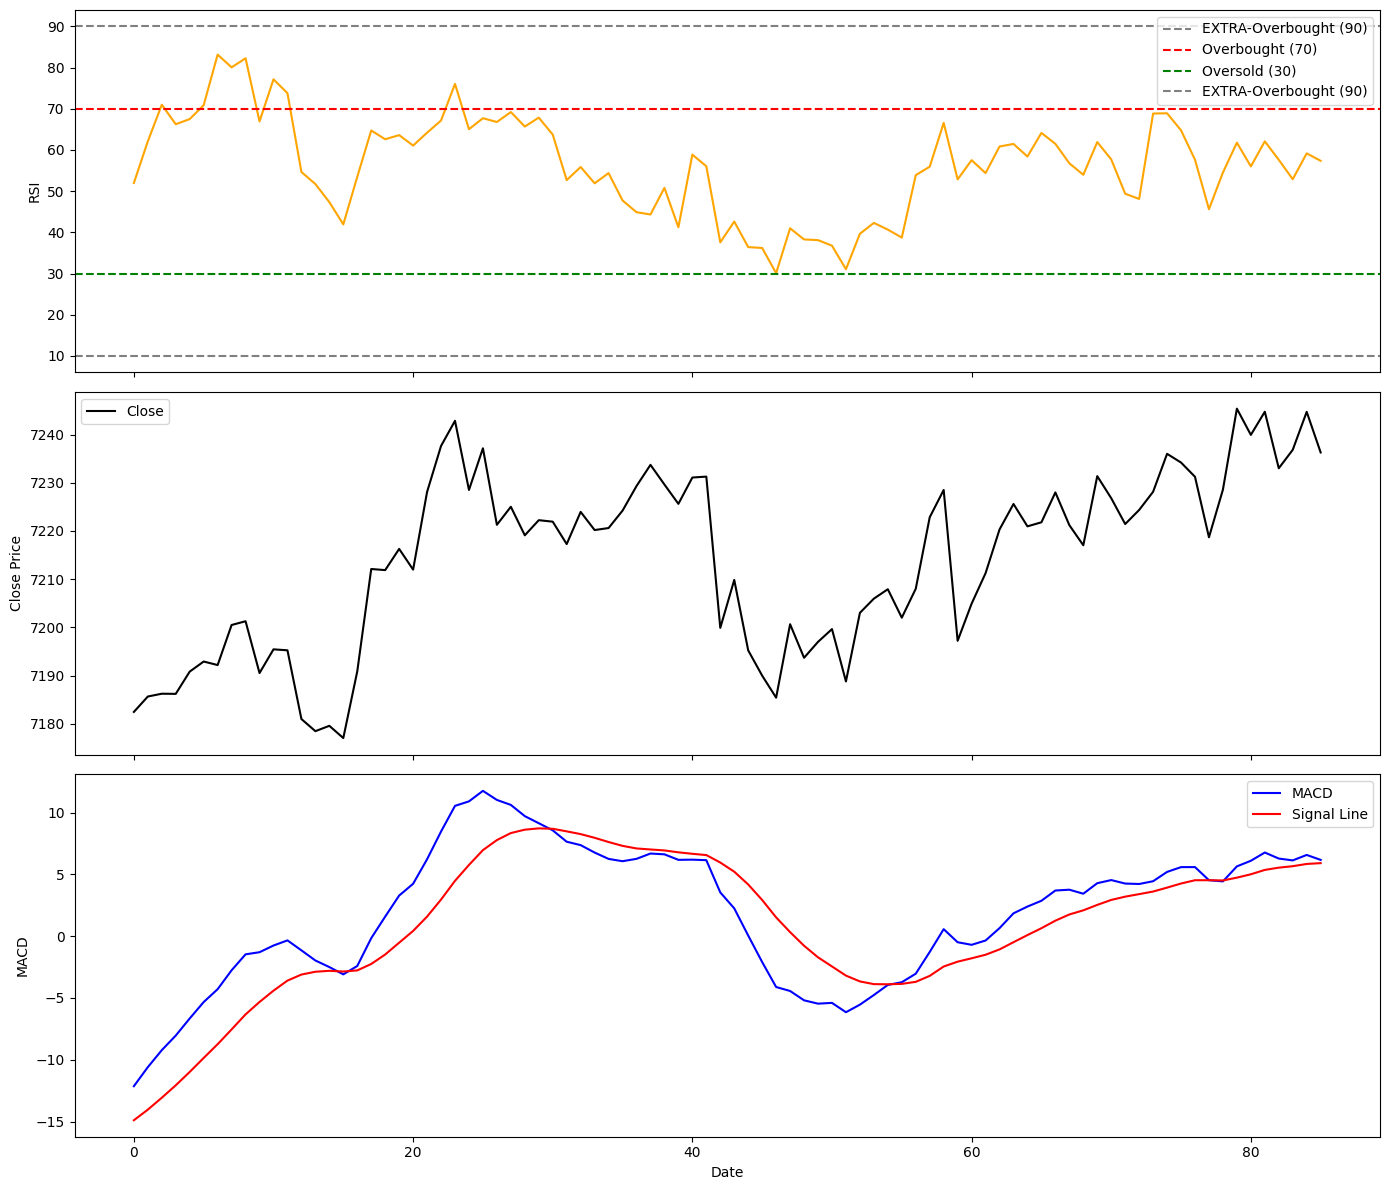

In [35]:
start_date = '2020-01-01'
end_date = '2020-01-02'

# Filter the data
s1 = test_df[(test_df['datetime'] >= start_date) & (test_df['datetime'] <= end_date)]
# For understanding the indicators

plot_df = s1.iloc[:,:]
plt.figure(figsize=(14, 6))

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 12), sharex=True)

# Plotting RSI
axes[0].plot(plot_df.index, plot_df['RSI'], color='orange')
axes[0].axhline(90, color='grey', linestyle='--', label='EXTRA-Overbought (90)')
axes[0].axhline(70, color='r', linestyle='--', label='Overbought (70)')
axes[0].axhline(30, color='g', linestyle='--', label='Oversold (30)')
axes[0].axhline(10, color='grey', linestyle='--', label='EXTRA-Overbought (90)')
axes[0].legend()
axes[0].set_ylabel('RSI')

# Plotting Close values and SMAs
axes[1].plot(plot_df.index, plot_df['close'], label='Close', color='black')
# axes[1].plot(plot_df['SMA_14'],label="14 previous average")
# axes[1].plot(plot_df['SMA_20'],label="20 previous average")
axes[1].legend()
axes[1].set_ylabel('Close Price')

# Plotting MACD and Signal Line
axes[2].plot(plot_df.index, plot_df['MACD'], label='MACD', color='blue')
axes[2].plot(plot_df.index, plot_df['Signal_Line'], label='Signal Line', color='red')
axes[2].legend()
axes[2].set_ylabel('MACD')
axes[2].set_xlabel('Date')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# plot_candlestick_chart(plot_df)

<Figure size 1400x600 with 0 Axes>

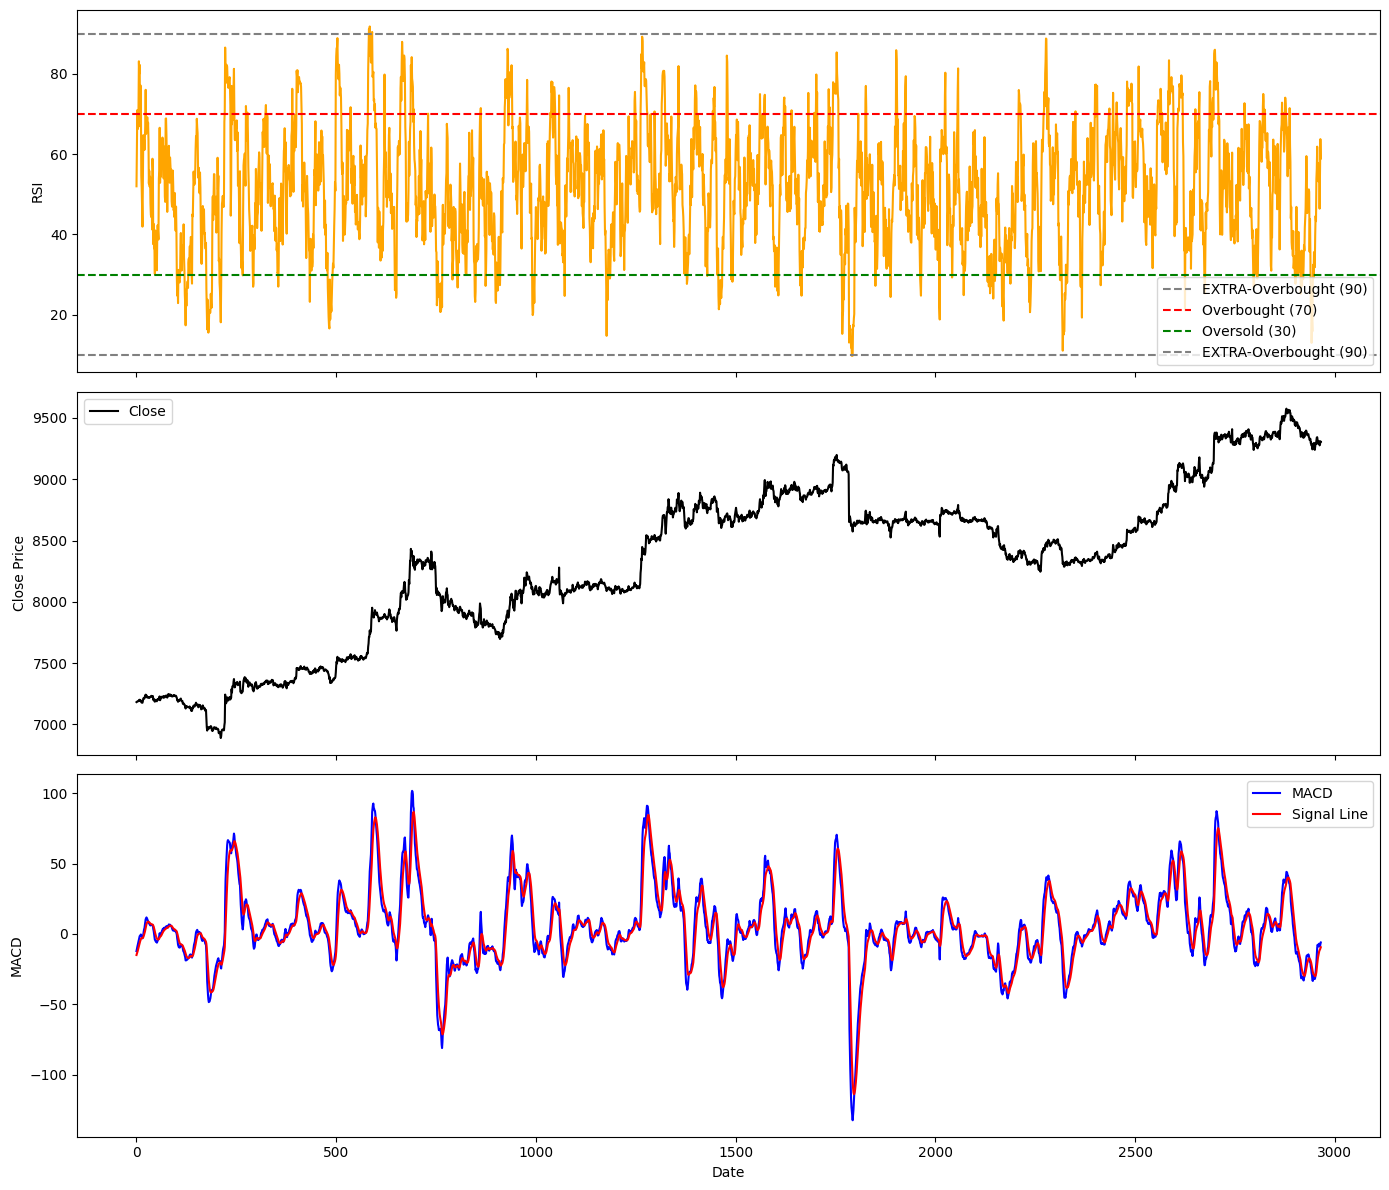

In [37]:
start_date = '2020-01-01'
end_date = '2020-02-01'

# Filter the data
s1 = test_df[(test_df['datetime'] >= start_date) & (test_df['datetime'] <= end_date)]
# For understanding the indicators

plot_df = s1.iloc[:,:]
plt.figure(figsize=(14, 6))

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 12), sharex=True)

# Plotting RSI
axes[0].plot(plot_df.index, plot_df['RSI'], color='orange')
axes[0].axhline(90, color='grey', linestyle='--', label='EXTRA-Overbought (90)')
axes[0].axhline(70, color='r', linestyle='--', label='Overbought (70)')
axes[0].axhline(30, color='g', linestyle='--', label='Oversold (30)')
axes[0].axhline(10, color='grey', linestyle='--', label='EXTRA-Overbought (90)')
axes[0].legend()
axes[0].set_ylabel('RSI')

# Plotting Close values and SMAs
axes[1].plot(plot_df.index, plot_df['close'], label='Close', color='black')
# axes[1].plot(plot_df['SMA_14'],label="14 previous average")
# axes[1].plot(plot_df['SMA_20'],label="20 previous average")
axes[1].legend()
axes[1].set_ylabel('Close Price')

# Plotting MACD and Signal Line
axes[2].plot(plot_df.index, plot_df['MACD'], label='MACD', color='blue')
axes[2].plot(plot_df.index, plot_df['Signal_Line'], label='Signal Line', color='red')
axes[2].legend()
axes[2].set_ylabel('MACD')
axes[2].set_xlabel('Date')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# plot_candlestick_chart(plot_df)

<Figure size 1400x600 with 0 Axes>

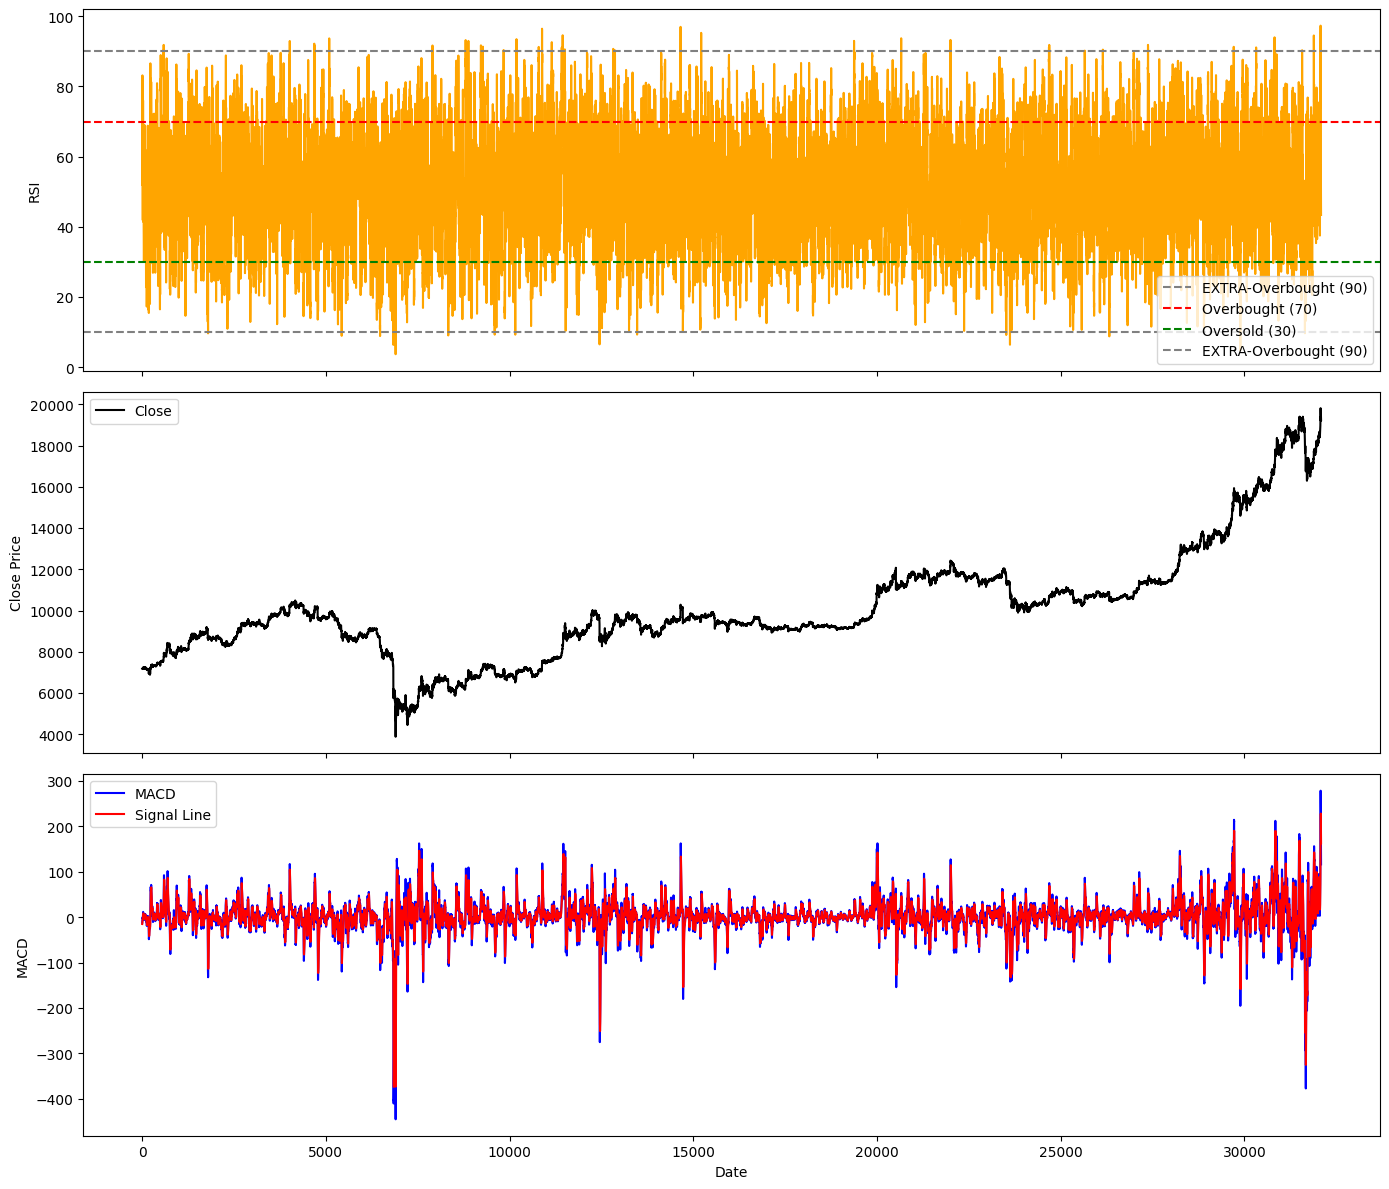

In [38]:
start_date = '2020-01-01'
end_date = '2020-12-01'

# Filter the data
s1 = test_df[(test_df['datetime'] >= start_date) & (test_df['datetime'] <= end_date)]
# For understanding the indicators

plot_df = s1.iloc[:,:]
plt.figure(figsize=(14, 6))

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 12), sharex=True)

# Plotting RSI
axes[0].plot(plot_df.index, plot_df['RSI'], color='orange')
axes[0].axhline(90, color='grey', linestyle='--', label='EXTRA-Overbought (90)')
axes[0].axhline(70, color='r', linestyle='--', label='Overbought (70)')
axes[0].axhline(30, color='g', linestyle='--', label='Oversold (30)')
axes[0].axhline(10, color='grey', linestyle='--', label='EXTRA-Overbought (90)')
axes[0].legend()
axes[0].set_ylabel('RSI')

# Plotting Close values and SMAs
axes[1].plot(plot_df.index, plot_df['close'], label='Close', color='black')
# axes[1].plot(plot_df['SMA_14'],label="14 previous average")
# axes[1].plot(plot_df['SMA_20'],label="20 previous average")
axes[1].legend()
axes[1].set_ylabel('Close Price')

# Plotting MACD and Signal Line
axes[2].plot(plot_df.index, plot_df['MACD'], label='MACD', color='blue')
axes[2].plot(plot_df.index, plot_df['Signal_Line'], label='Signal Line', color='red')
axes[2].legend()
axes[2].set_ylabel('MACD')
axes[2].set_xlabel('Date')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# plot_candlestick_chart(plot_df)

In [95]:
close1=pred_cls
actc1=act_cls

In [96]:
close2=pred_cls[0:400]
actc2=act_cls[0:400]

In [97]:
close3=pred_cls[0:200]
actc3=act_cls[0:200]

In [98]:
close4=pred_cls[0:80]
actc4=act_cls[0:80]

In [99]:
close5=pred_cls[0:20]
actc5=act_cls[0:20]

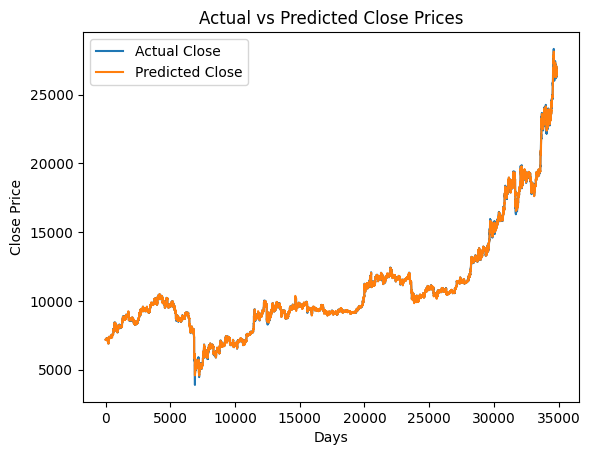

In [100]:
days = range(1, len(close1) + 1)

# Plotting the actual close prices
plt.plot(days, actc1, label='Actual Close')

# Plotting the predicted close prices
plt.plot(days, close1, label='Predicted Close' )

# Adding labels and title
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices')

# Adding a legend
plt.legend()
# Display the plot
plt.show()

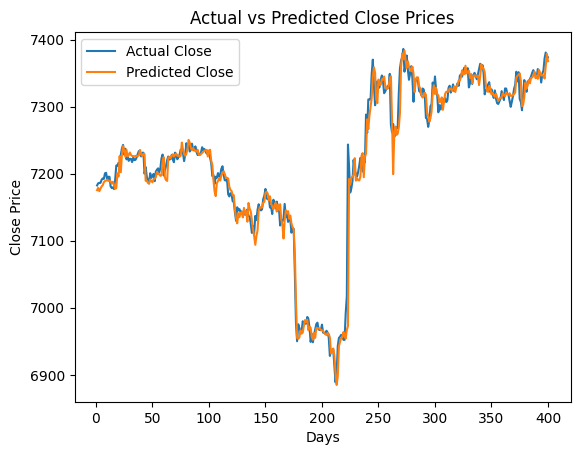

In [101]:
days = range(1, len(close2) + 1)

# Plotting the actual close prices
plt.plot(days, actc2, label='Actual Close')

# Plotting the predicted close prices
plt.plot(days, close2, label='Predicted Close' )

# Adding labels and title
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices')

# Adding a legend
plt.legend()
# Display the plot
plt.show()

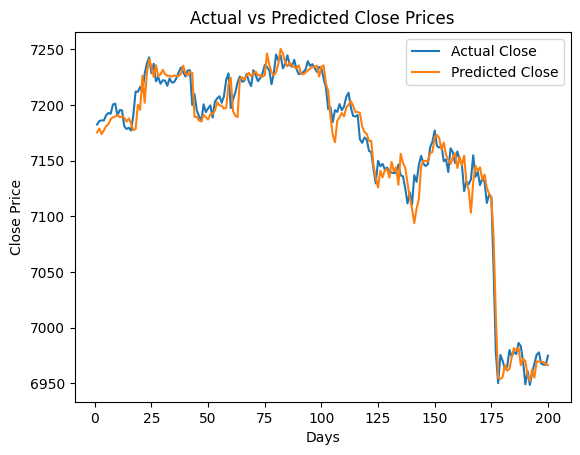

In [102]:
days = range(1, len(close3) + 1)

# Plotting the actual close prices
plt.plot(days, actc3, label='Actual Close')

# Plotting the predicted close prices
plt.plot(days, close3, label='Predicted Close' )

# Adding labels and title
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices')

# Adding a legend
plt.legend()
# Display the plot
plt.show()

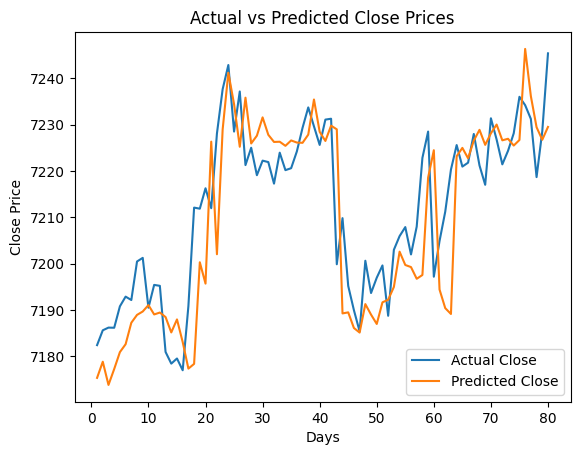

In [103]:
days = range(1, len(close4) + 1)

# Plotting the actual close prices
plt.plot(days, actc4, label='Actual Close')

# Plotting the predicted close prices
plt.plot(days, close4, label='Predicted Close' )

# Adding labels and title
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices')

# Adding a legend
plt.legend()
# Display the plot
plt.show()

In [106]:
open = test_df['open'].tolist()

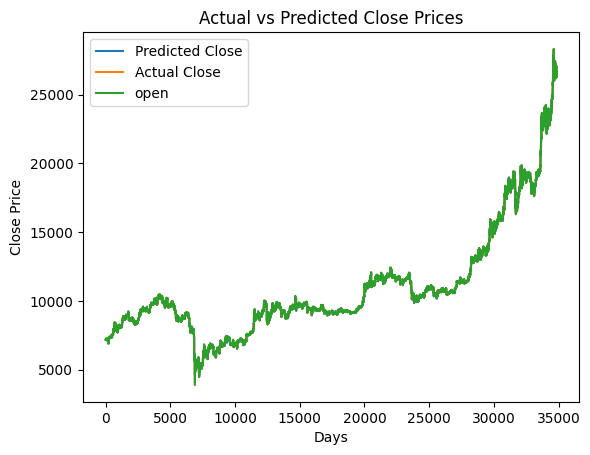

In [107]:
import matplotlib.pyplot as plt

days = range(1, len(close1) + 1)
plt.plot(days, close1, label='Predicted Close' )
# Plotting the actual close prices
plt.plot(days, actc1, label='Actual Close')

plt.plot(days, open, label='open')

# Plotting the predicted close prices


# Adding labels and title
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices')

# Adding a legend
plt.legend()
# Display the plot
plt.show()

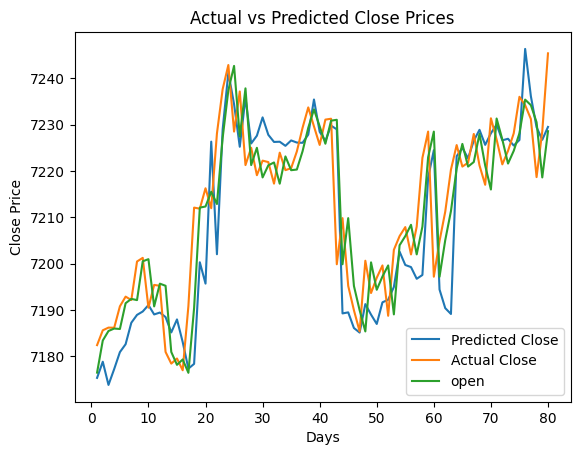

In [110]:
import matplotlib.pyplot as plt
open4=open[0:80]
days = range(1, len(close4) + 1)
plt.plot(days, close4, label='Predicted Close' )
# Plotting the actual close prices
plt.plot(days, actc4, label='Actual Close')

plt.plot(days, open4, label='open')

# Plotting the predicted close prices


# Adding labels and title
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices')

# Adding a legend
plt.legend()
# Display the plot
plt.show()

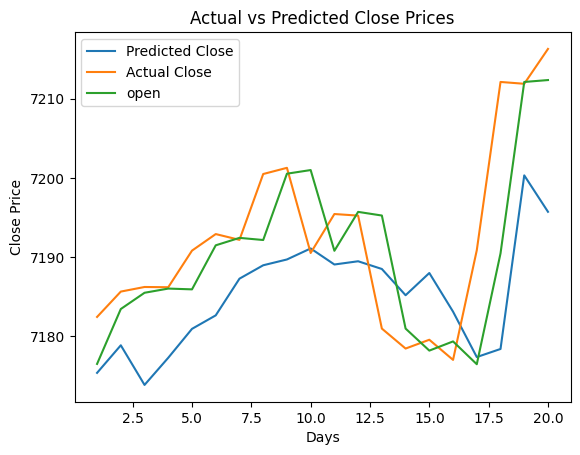

In [112]:
import matplotlib.pyplot as plt
open5=open[0:20]
days = range(1, len(close5) + 1)
plt.plot(days, close5, label='Predicted Close' )
# Plotting the actual close prices
plt.plot(days, actc5, label='Actual Close')

plt.plot(days, open5, label='open')

# Plotting the predicted close prices


# Adding labels and title
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices')

# Adding a legend
plt.legend()
# Display the plot
plt.show()